In [1]:
import json
from typing import Tuple, Any, List

import pandas as pd
import numpy as np
import joblib
from termcolor import colored
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    precision_score, 
    recall_score,
    accuracy_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

In [2]:
train_data = pd.read_csv('../../dataset/classification/train.csv')
test_data = pd.read_csv('../../dataset/classification/test.csv')

Delimo ulazne i izlazne atribute. Za X_train / X_test uzimamo sve instance sa atributima do poslednjeg. Za Y_train / Y_test uzimamo sve instance i to samo poslednji atribut.

In [3]:
X_train = train_data.iloc[:, :-1]
Y_train = train_data.iloc[:, -1:]

X_test = test_data.iloc[:, :-1]
Y_test = test_data.iloc[:, -1:]

Delimo X_train podatke na podatke za treniranje modela i podatke za validaciju modela. Podatke za validaciju modela koristimo da ne bi kompromitovali podatke za testiranje prilikom odredjivanja parametra raznih modela

In [4]:
(X_train, X_val, Y_train, Y_val) = train_test_split(X_train, Y_train, test_size=0.20, random_state=42, stratify=Y_train)

In [5]:
def score_model(Y_true: pd.DataFrame, Y_pred: np.ndarray) -> Tuple[float, float, float, float]:
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    accuracy = accuracy_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred)
    
    return (precision, recall, accuracy, f1)

In [6]:
# Ovaj deo koda je preuzet sa vezbi uz malu modifikaciju
def report(model: Any, X_test: pd.DataFrame, Y_test: pd.Series, text: str = 'training') -> None:
    Y_pred = model.predict(X_test)
    
    print(colored(f'Classification report for model {type(model).__name__} on {text} data', 'green'))
    print('---------------------------------------------------------------------------------')
    print(classification_report(Y_test, Y_pred))
    print('---------------------------------------------------------------------------------')
    
    print(colored(f'Confusion matrix for model {type(model).__name__} on {text} data ', 'green'))
    print('---------------------------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(Y_test, Y_pred), columns=['0', '1'], index=['0', '1']))
    print('---------------------------------------------------------------------------------')
    

def plot_decision_tree(model: Any, feature_names: List[str]) -> None:
    plt.figure(figsize=(7, 7))
    plot_tree(model, class_names=['0', '1'], feature_names=feature_names, filled=True)
    plt.title(f'Decision tree of depth {model.get_depth()} with {model.get_n_leaves()} nodes')

    plt.show()
    print('---------------------------------------------------------------------------------')
    print(colored(f'Parameters of model {type(model).__name__}', 'green'))
    for k, v in model.get_params().items():
        print(colored(k, 'blue'), v)
    
    print('---------------------------------------------------------------------------------')

## Stablo odlucivanja

Treniranje modela

In [7]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(X_train, Y_train)

DecisionTreeClassifier()

Koliko dobro nas model radi na trening odnosno test podacima bez ikakvog prilagodjavanja parametra dubine stabla?

In [8]:
report(dtc_model, X_train, Y_train, 'train')
report(dtc_model, X_test, Y_test, 'test')

Classification report for model DecisionTreeClassifier on train data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15391
           1       1.00      1.00      1.00     15391

    accuracy                           1.00     30782
   macro avg       1.00      1.00      1.00     30782
weighted avg       1.00      1.00      1.00     30782

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on train data 
---------------------------------------------------------------------------------
       0      1
0  15355     36
1      6  15385
---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
             

Iako na trening skupu model deluje da radi savrseno, doslo je do preprilagodjavanja sto pokazuju rezultati na test skupu.

Trazimo odgovarajuci model koji je najefikasniji na osnovu hiper parametra.  
Vazno je napomenuti da predikcije vrsimo nad podacima za validaciju da ne bi kompromitovali test skup

In [9]:
dtc_results = {}
depths = [2, 6, 10, 20, 30, 40, 50, 60, 70, 80]

for depth in depths:
    dtc_model = DecisionTreeClassifier(max_depth=depth)
    dtc_model.fit(X_train, Y_train)
    
    Y_pred = dtc_model.predict(X_val)
    
    (precision, recall, accuracy, f1) = score_model(Y_val, Y_pred)
    
    dtc_results[depth] = {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1': f1
    }

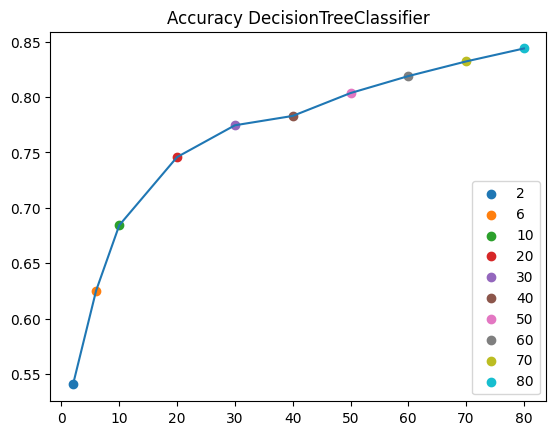

In [11]:
for d, acc in zip(depths, [dtc_results[key]['accuracy'] for key in dtc_results]):
    plt.scatter(d, acc, label=d)
    
plt.plot(depths, [dtc_results[key]['accuracy'] for key in dtc_results])
plt.legend()
plt.title('Accuracy DecisionTreeClassifier')
plt.show()

In [12]:
criterions = ['gini', 'entropy']
dtc_results_criterion = {}

for criterion in criterions:
    dtc_model = DecisionTreeClassifier(max_depth=80, criterion=criterion)
    dtc_model.fit(X_train, Y_train)
    
    Y_pred = dtc_model.predict(X_val)
    
    (precision, recall, accuracy, f1) = score_model(Y_val, Y_pred)
    
    dtc_results_criterion[criterion] = {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1': f1
    }

In [13]:
print(json.dumps(dtc_results_criterion, indent=4))

{
    "gini": {
        "precision": 0.9436808581964465,
        "recall": 0.7315488565488566,
        "accuracy": 0.8439449064449065,
        "f1": 0.8241838676621285
    },
    "entropy": {
        "precision": 0.9594281298299846,
        "recall": 0.6452702702702703,
        "accuracy": 0.808991683991684,
        "f1": 0.7715972653822251
    }
}


In [14]:
best_dtc_model = DecisionTreeClassifier(max_depth=80, criterion='gini')
best_dtc_model.fit(X_train, Y_train)

report(best_dtc_model, X_test, Y_test, 'test')

Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8245
           1       0.49      0.51      0.50       603

    accuracy                           0.93      8848
   macro avg       0.73      0.74      0.73      8848
weighted avg       0.93      0.93      0.93      8848

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on test data 
---------------------------------------------------------------------------------
      0    1
0  7921  324
1   293  310
---------------------------------------------------------------------------------


Povecavanjem dubine stabla rezultati ne postaju znacajnije bolji. Iz prilozenog se moze videti da su ocene za tweetove koji sadrze govor mrznje znacajno losije od tweetova koji ne sadrze govor mrznje, sto nije iznenadjujuce s obzirom da je nas originalni skup sadrzao 93% tweetova koji su okarakterisani da ne sadrze govor mrznje.

## Slucajne sume

Parametar `n_estimators` je broj stabala u sumi. U zavisnosti od datog parametra ispitacemo kako se ponasa preciznost naseg modela i izabracemo najbolji parametar

In [18]:
rf_results = {}
n_estimators = range(10, 101, 10)

for n in n_estimators:
    rf_model = RandomForestClassifier(n_estimators=n)
    rf_model.fit(X_train, Y_train.values.ravel())
    
    Y_pred = rf_model.predict(X_val)
    
    (precision, recall, accuracy, f1) = score_model(Y_val, Y_pred)
    
    rf_results[n] = {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1': f1
    }

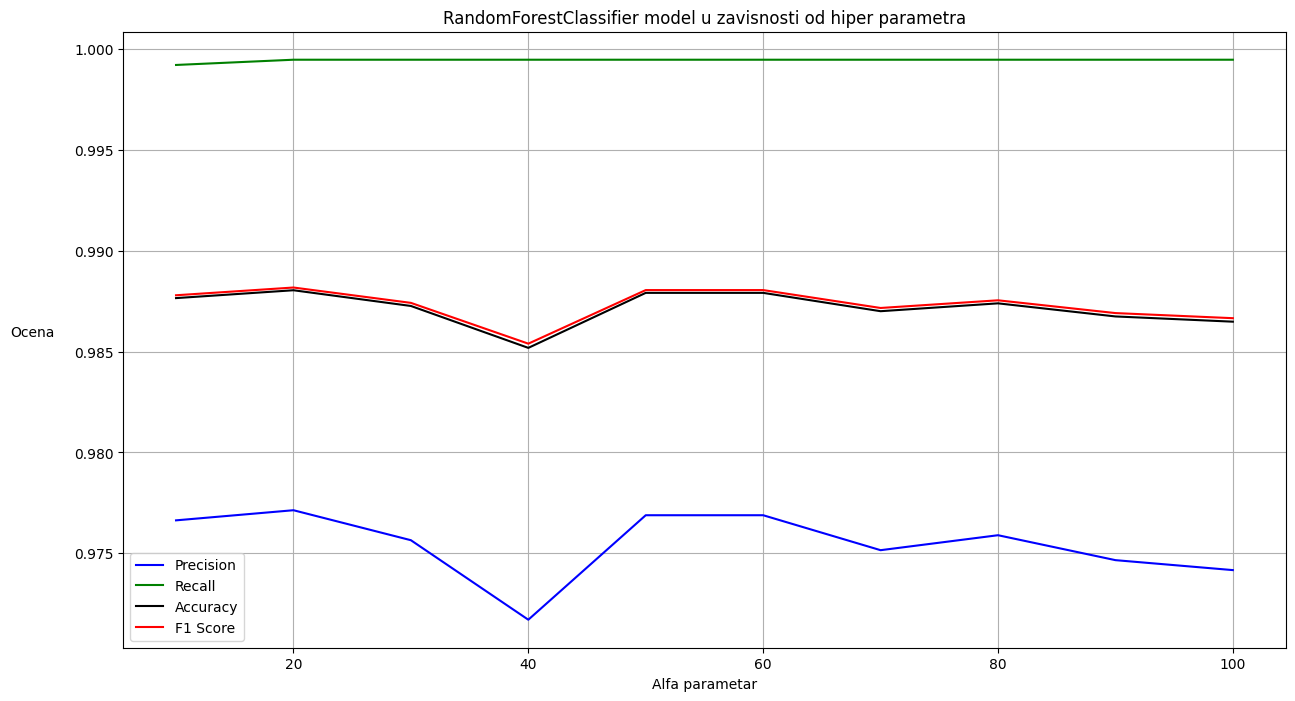

In [19]:
precisions = [rf_results[n]['precision'] for n in rf_results]
recalls = [rf_results[n]['recall'] for n in rf_results]
accuracies = [rf_results[n]['accuracy'] for n in rf_results]
f1s = [rf_results[n]['f1'] for n in rf_results]

plt.figure(figsize=(15, 8))

plt.plot(n_estimators, precisions, color='blue', label='Precision')
plt.plot(n_estimators, recalls, color='green', label='Recall')
plt.plot(n_estimators, accuracies, color='black', label='Accuracy')
plt.plot(n_estimators, f1s, color='red', label='F1 Score')

plt.title('RandomForestClassifier model u zavisnosti od hiper parametra')
plt.xlabel('Alfa parametar')
plt.ylabel('Ocena', rotation=0, labelpad=30)
plt.grid(True)
plt.legend()

plt.show()

In [26]:
best_estimator = 0
best_accuracy = rf_results[10]['accuracy']
for estimator in rf_results:
    if rf_results[estimator]['accuracy'] > best_accuracy:
        best_estimator = estimator
        best_accuracy = rf_results[estimator]['accuracy']

print(f'Najbolji parametar: {best_estimator}')
print(f'Precision: {rf_results[best_estimator]["precision"]}')
print(f'Recall: {rf_results[best_estimator]["recall"]}')
print(f'Accuracy: {rf_results[best_estimator]["accuracy"]}')
print(f'F1: {rf_results[best_estimator]["f1"]}')

Najbolji parametar: 20
Precision: 0.9771341463414634
Recall: 0.9994802494802495
Accuracy: 0.988045738045738
F1: 0.9881808838643371


In [27]:
best_random_forest = RandomForestClassifier(n_estimators=best_estimator)
best_random_forest.fit(X_train, Y_train.values.ravel())

report(best_random_forest, X_test, Y_test, 'test')

Classification report for model RandomForestClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      8245
           1       0.67      0.57      0.61       603

    accuracy                           0.95      8848
   macro avg       0.82      0.77      0.79      8848
weighted avg       0.95      0.95      0.95      8848

---------------------------------------------------------------------------------
Confusion matrix for model RandomForestClassifier on test data 
---------------------------------------------------------------------------------
      0    1
0  8074  171
1   260  343
---------------------------------------------------------------------------------


## Poredjenje modela

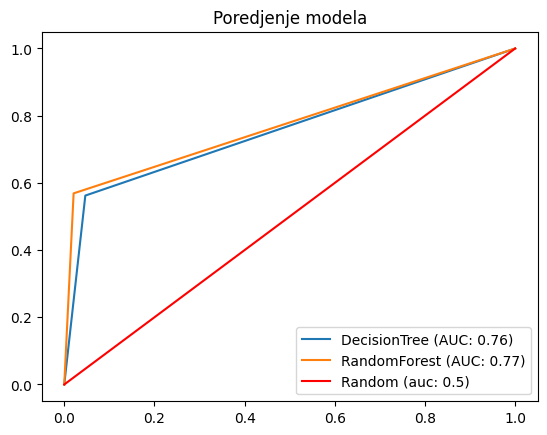

In [28]:
models = [best_dtc_model, best_random_forest]
model_names = ['DecisionTree', 'RandomForest']

for (model, model_name) in zip(models, model_names):
    Y_pred = model.predict(X_test)
    
    (fpr,tpr, _) = roc_curve(Y_test, Y_pred)
    auc = roc_auc_score(Y_test, Y_pred)
    
    model_label = f'{model_name} (AUC: {auc:,.2f})'
    
    plt.plot(fpr, tpr, label=model_label)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title('Poredjenje modela')
plt.legend(loc=4)
plt.show()

Najvecu AUC vrednost ima model `RandomForest`: 0.77  
Sledeci korak je cuvanje modela, i za to cemo koristiti biblioteku `joblib`

In [29]:
joblib.dump(best_random_forest, 'decision_tree.joblib')

['decision_tree.joblib']